In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz# For normalizing the theoretical density plot

# --- 1. Define the Log Unnormalized Posterior Distribution ---
def log_unnormalized_posterior(theta):
    """
    Calculates the logarithm of the unnormalized posterior density for theta.
    
    The posterior is proportional to: 
    L(theta) * P(theta) = [((1+theta)/2)^80 * ((1-theta)/2)^20] * [theta^3 * (1-theta)]
    
    The domain for theta is (0, 1).
    """
    # 1. Constraint Check: Ensure theta is within the domain (0, 1)
    if not (0.0 < theta < 1.0):
        # Using -np.inf ensures any proposal outside the domain is immediately rejected
        return -np.inf
    
    # 2. Log-Likelihood Term: log(L(theta))
    # We use log rules to avoid numerical instability: log(a*b) = log(a) + log(b)
    log_likelihood = (
        80 * np.log((1 + theta) / 2) +
        20 * np.log((1 - theta) / 2)
    )
    
    # 3. Log-Prior Term: log(P(theta))
    log_prior = (
        3 * np.log(theta) +
        1 * np.log(1 - theta)
    )
    
    return log_likelihood + log_prior

# --- 2. Implement the Metropolis Sampling Function ---
def metropolis_sampling(log_target_pdf, proposal_sd, initial_guess, n_samples):
    """
    Generates samples using the Random Walk Metropolis algorithm.

    Args:
        log_target_pdf (function): Logarithm of the unnormalized target PDF.
        proposal_sd (float): Standard deviation for the symmetric Gaussian proposal.
        initial_guess (float): Starting value for the Markov chain.
        n_samples (int): The total number of iterations.

    Returns:
        numpy.ndarray: An array of the generated samples.
    """
    samples = np.zeros(n_samples)
    current_theta = initial_guess
    accept_count = 0
    
    # Start with the log-posterior value at the initial guess
    current_log_pi = log_target_pdf(current_theta)

    for i in range(n_samples):
        # A. Propose a new candidate (Symmetric Gaussian Random Walk)
        candidate_theta = np.random.normal(current_theta, proposal_sd)
        
        # B. Calculate the log acceptance ratio
        candidate_log_pi = log_target_pdf(candidate_theta)
        
        # log(r) = log(pi_candidate) - log(pi_current)
        # Note: Since the proposal is symmetric, the Hastings ratio Q(x_t|x_cand)/Q(x_cand|x_t) = 1, so log(Hastings Ratio) = 0.
        log_ratio = candidate_log_pi - current_log_pi
        
        # C. Calculate log(acceptance_probability) = log(min(1, r)) = min(0, log(r))
        log_acceptance_prob = min(0, log_ratio) 

        # D. Accept or Reject
        # We compare log(u) with log(acceptance_prob)
        # log(u) is always less than 0 since u is in (0, 1)
        log_u = np.log(np.random.uniform(0, 1))
        
        if log_u < log_acceptance_prob:
            # Accept the new state
            current_theta = candidate_theta
            current_log_pi = candidate_log_pi
            accept_count += 1
        
        samples[i] = current_theta
        
    acceptance_rate = accept_count / n_samples
    print(f"Acceptance Rate: {acceptance_rate:.2f}")
    return samples

# --- 3. Parameters and Execution ---
N_SAMPLES = 100000
PROPOSAL_SD = 0.05  # Tuning parameter: Adjust this for optimal acceptance rate (aim for 20-50%)
INITIAL_GUESS = 0.5 # Start in the middle of the domain (0, 1)
BURN_IN = 10000     # Discard the first 10,000 samples

print("Starting Metropolis sampling for the posterior...")
metropolis_samples = metropolis_sampling(
    log_unnormalized_posterior, 
    PROPOSAL_SD, 
    INITIAL_GUESS, 
    N_SAMPLES
)

final_samples = metropolis_samples[BURN_IN:]

# --- 4. Plotting and Summary ---

# Generate the theoretical posterior density for plotting
theta_range = np.linspace(0.001, 0.999, 500)
log_density = np.array([log_unnormalized_posterior(t) for t in theta_range])

# Convert back to unnormalized density
unnormalized_density = np.exp(log_density - np.max(log_density)) # Subtract max for stability before exp

# Normalize the density using numerical integration (Trapezoidal Rule)
# This is necessary to compare with the 'density=True' histogram
normalization_constant = trapz(unnormalized_density, theta_range)
normalized_posterior_pdf = unnormalized_density / normalization_constant

Starting Metropolis sampling for the posterior...
Acceptance Rate: 0.79


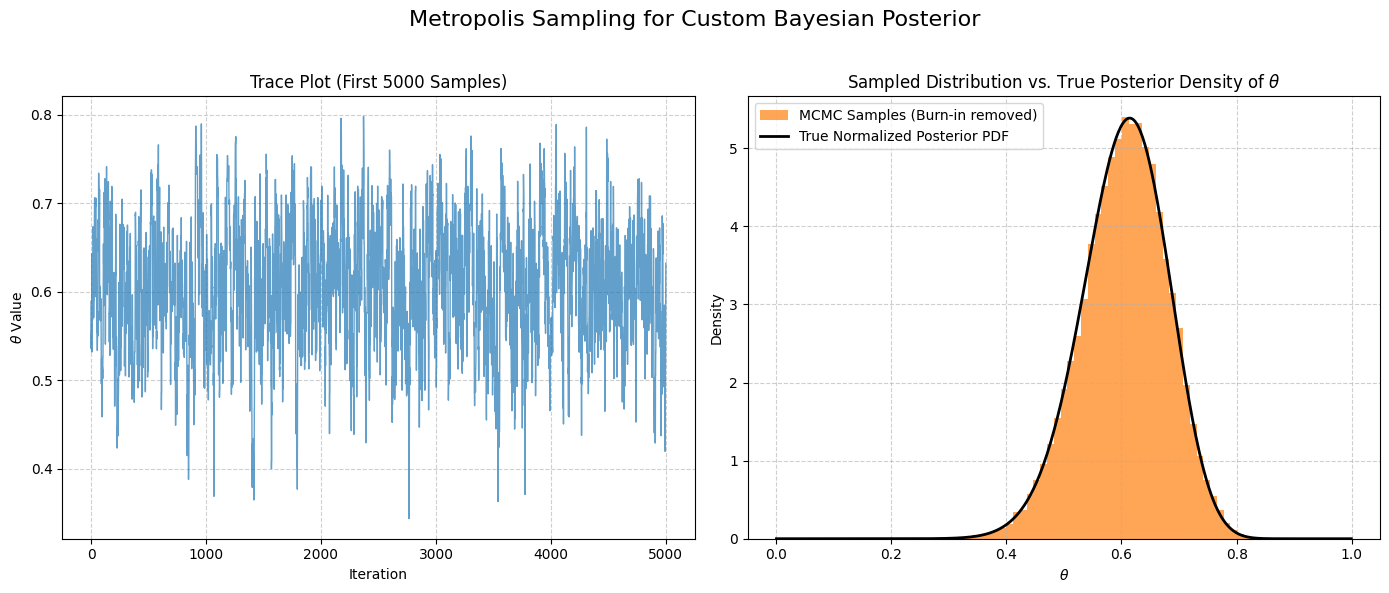


--- Summary Statistics ---
Total Samples (after burn-in): 90000
Posterior Mean of theta: 0.6051
Posterior Standard Deviation: 0.0746
95% Credible Interval (2.5% to 97.5%): (0.4498, 0.7417)


In [5]:
# Create plots
plt.figure(figsize=(14, 6))

# Subplot 1: Trace Plot
plt.subplot(1, 2, 1)
plt.plot(metropolis_samples[:5000], color='#1f77b4', alpha=0.7, linewidth=1)
plt.title('Trace Plot (First 5000 Samples)')
plt.xlabel('Iteration')
plt.ylabel(r'$\theta$ Value')
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot 2: Histogram vs. True Density
plt.subplot(1, 2, 2)
plt.hist(final_samples, bins=50, density=True, label='MCMC Samples (Burn-in removed)', color='#ff7f0e', alpha=0.7)
plt.plot(theta_range, normalized_posterior_pdf, 'k-', linewidth=2, label='True Normalized Posterior PDF')
plt.title(r'Sampled Distribution vs. True Posterior Density of $\theta$')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Metropolis Sampling for Custom Bayesian Posterior', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print summary statistics
print("\n--- Summary Statistics ---")
print(f"Total Samples (after burn-in): {len(final_samples)}")
print(f"Posterior Mean of theta: {np.mean(final_samples):.4f}")
print(f"Posterior Standard Deviation: {np.std(final_samples):.4f}")
print(f"95% Credible Interval (2.5% to 97.5%): ({np.percentile(final_samples, 2.5):.4f}, {np.percentile(final_samples, 97.5):.4f})")
